In [95]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import json
import sys

from pathlib import Path
import pandas as pd
from scipy.io import wavfile
from IPython.display import display
from functional import seq

sys.path.append("..")
from sgs_utils.path_conf import speech_data_root_dir_v2, loc_data_dir

speech_data_session_dir = speech_data_root_dir_v2.joinpath("backup")
display(speech_data_session_dir)

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.plotting.backend = "plotly"


PosixPath('/media/speech_webapp_v2/backup')

In [115]:
# !wget --output-document="speech_data_webapp.zip" https://cloud.ilabt.imec.be/index.php/s/tB2enWmZCJskGmG/download
# !unzip speech_data_webapp.zip
# !mv speech_web_app /project_scratch/data/
# !rm speech_data_webapp.zip


In [116]:
# so we have all folders in backup?
!ls -lh {speech_data_session_dir} | head -n 10

total 0
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-04-21__13:54:00+02:00__02f9a947-f362-4793-ab8a-bfbe0214444e
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-04-21__15:15:00+02:00__1937d1f5-7edf-41b6-afae-644c0c8c55f9
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:18 2022-04-22__10:02:00+02:00__6584e78d-d270-4183-b371-887e6f10acb0
drwxr-xr-x 4 jonas jonas 56 Jun 27 07:18 2022-04-25__10:15:00+02:00__71d32b4f-3869-4823-aec0-231b662ee6fc
drwxr-xr-x 5 jonas jonas 71 Jun 27 07:18 2022-04-25__15:17:00+02:00__ed7e3b2b-55b7-48ce-83d4-ab4f4a47d8e8
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-04-25__15:35:00+02:00__3f2cc5d3-1fc4-4cd2-8746-dc6891c764d3
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-04-25__20:34:00+02:00__cbc80b5e-d8d5-4768-848e-d4f942852de0
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-05-11__10:57:00+02:00__e9e26b7f-a16f-4202-86a4-4890d6928e88
drwxr-xr-x 2 jonas jonas 27 Jun 27 07:18 2022-05-11__11:42:00+02:00__6def4030-c2de-4302-9ce9-c47e22a8c1c0


In [117]:
# This snippet summarizes the dir-names of the various folders
# within `speech_data_session_dir`
dir_list = []
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue
    dir_list.extend(
        seq(folder.iterdir())
        .filter(lambda x: x.is_dir())
        .map(lambda x: x.name)
        .to_list()
    )
print(pd.Series(dir_list).value_counts())
del dir_list, folder


marloes    54
PiSCES     52
Radboud    50
dtype: int64


## Creating the metadata file

The metadata file is constructed of the `.json` file which resides within each user ID 
folder and withholds the person's metadata such as gender, age, education, used mic. etc ...

In [118]:
metadata_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    metadata = folder.joinpath("metadata.json")
    if not metadata.is_file():
        continue

    with open(metadata, "r") as f:
        metadata_dict = json.load(f)
    metadata_dict["ID"] = folder.name.split("__")[-1]

    metadata_dict["Marloes"] = len(list(folder.joinpath("marloes").glob("*.wav")))
    metadata_dict["PiSCES"] = len(list(folder.joinpath("PiSCES").glob("*.wav")))
    metadata_dict["Radboud"] = len(list(folder.joinpath("Radboud").glob("*.wav")))

    metadata_dict_list.append(metadata_dict)

df_metadata = pd.DataFrame(metadata_dict_list)

# conver the columns to the correct data format
df_metadata["age"] = df_metadata["age"].astype(int)
df_metadata[["sex", "device", "education"]] = df_metadata[
    ["sex", "device", "education"]
].astype("category")
df_metadata["timestamp"] = pd.to_datetime(
    df_metadata.timestamp, utc=True
).dt.tz_convert("Europe/Brussels")

del folder, metadata_dict, metadata_dict_list, f, metadata


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>], dtype=object)

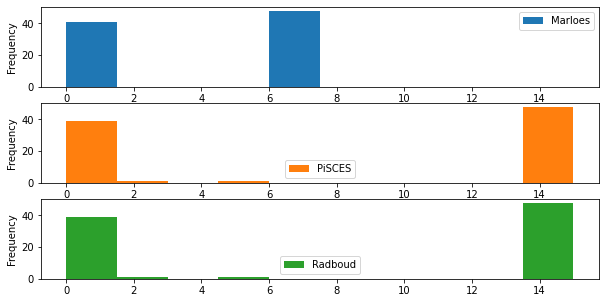

In [101]:
df_metadata[["Marloes", "PiSCES", "Radboud"]].plot(
    subplots=True, kind="hist", figsize=(10, 5), sharex=False, backend="matplotlib"
)


In [102]:
df_metadata_relevant = (
    df_metadata[
        (df_metadata.Marloes >= 6)
        & (df_metadata.Radboud >= 13)
        & (df_metadata.PiSCES >= 13)
    ]
    .reset_index(drop=True)
    .copy()
)


In [106]:
display(df_metadata_relevant.columns)
df_metadata_relevant[
    ["age", "sex", "device", "Marloes", "PiSCES", "Radboud"]
].describe()


Index(['age', 'device', 'education', 'sex', 'timestamp', 'ID', 'Marloes',
       'PiSCES', 'Radboud', 'prolific_token'],
      dtype='object')

,age,Marloes,PiSCES,Radboud
count,48.000000,48.0,48.0,48.0
mean,29.083333,7.0,15.0,15.0
std,11.763328,0.0,0.0,0.0
min,19.000000,7.0,15.0,15.0
25%,23.000000,7.0,15.0,15.0
50%,25.000000,7.0,15.0,15.0
75%,32.000000,7.0,15.0,15.0
max,90.000000,7.0,15.0,15.0


female    26
male      22
other      0
Name: sex, dtype: int64

--------------------------------------------------------------------------------


pc-mic       26
headset      11
earphones     7
other         4
Name: device, dtype: int64

--------------------------------------------------------------------------------


array([<AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>,
       <AxesSubplot:ylabel='Frequency'>, <AxesSubplot:ylabel='Frequency'>],
      dtype=object)

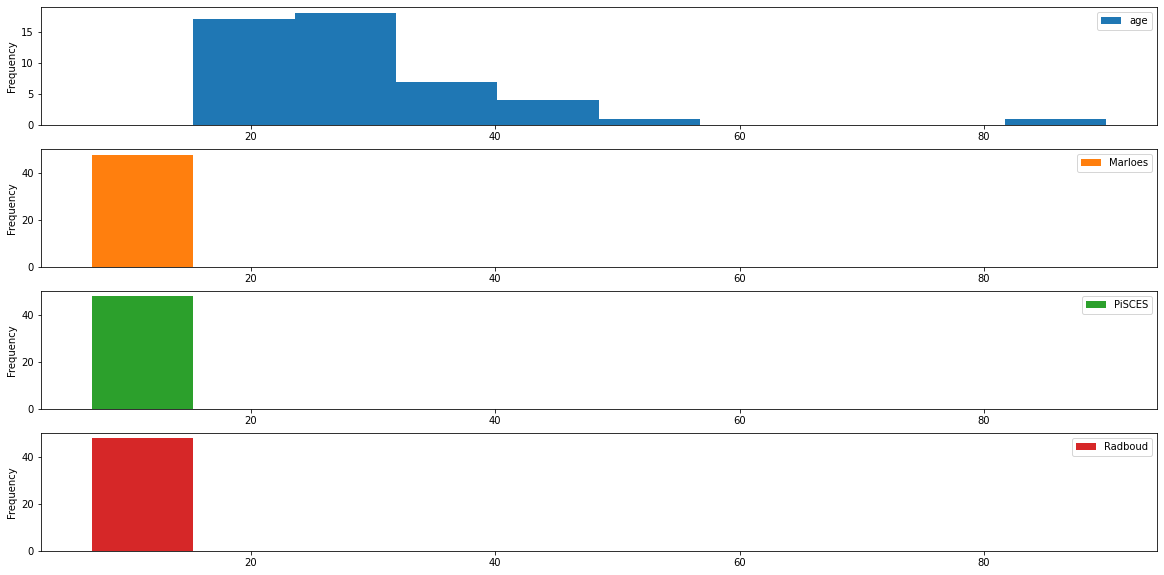

In [112]:
display(df_metadata_relevant.sex.value_counts())
print("-" * 80)
display(df_metadata_relevant.device.value_counts())
print("-" * 80)
df_metadata_relevant.education.value_counts()

# Also plot the age 
df_metadata_relevant[["age", "device", "Marloes", "PiSCES", "Radboud"]].plot(
    kind="hist", subplots=True, sharex=False, figsize=(20, 10), backend="matplotlib"
)


## Distilling sessions from the relevant metadata

In [17]:
session_dict_list = []

# creating alldata.csv
for folder in speech_data_session_dir.iterdir():
    if not folder.is_dir():
        continue

    def parse_pic_name_ts(db_folder, pic_name, time_str, sep="__") -> dict:
        # what can we save from the wave file?
        # duration - size
        json_f = sep.join([pic_name, time_str]) + ".json"
        json_f = db_folder.joinpath(json_f)
        if not json_f.is_file():
            # print('json_f does not exist')
            return {}

        with open(json_f, "r") as f:
            return json.load(f)

    # TODO -> maybe we can also use the wav duration here as an extra assert.
    def get_wav_json_mapping(db_folder: Path) -> dict:
        # parse the wav files to construct a dataframe
        wav_list = list(db_folder.glob("*.wav"))
        df_db_wav = pd.Series(
            seq(wav_list).map(lambda x: x.name), name="wav_files", dtype="str"
        ).to_frame()
        df_db_wav["wav_time_str"] = df_db_wav["wav_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_wav["wav_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_wav["wav_time_str"], infer_datetime_format=True
        )
        df_db_wav = df_db_wav.sort_values(by="wav_time_str")

        # parse the json files to construct a datafraem
        json_list = list(db_folder.glob("*.json"))
        df_db_json = pd.Series(
            seq(json_list).map(lambda x: x.name), name="json_files", dtype="str"
        ).to_frame()
        df_db_json["json_time_str"] = df_db_json["json_files"].map(
            lambda x: x.split("__")[1].split(".")[0]
        )
        df_db_json["json_time_str"] = pd.to_datetime(
            "2022/01/01 " + df_db_json["json_time_str"], infer_datetime_format=True
        )
        df_db_json = df_db_json.sort_values(by="json_time_str")

        json_wav_mapping = pd.merge_asof(
            left=df_db_wav,
            right=df_db_json,
            left_on="wav_time_str",
            right_on="json_time_str",
            tolerance=pd.Timedelta(minutes=3),
            # A "forward" search selects the first row in the right DataFrame whose 'on' key
            # is greater than or equal to the left's key.
            direction="forward",
        )

        json_wav_mapping = json_wav_mapping.dropna(how="any", axis=0)
        json_wav_mapping = json_wav_mapping[
            ~(
                json_wav_mapping["wav_time_str"]
                < json_wav_mapping["json_time_str"].shift(1)
            )
        ].reset_index(drop=True)

        assert all(
            (
                json_wav_mapping["json_time_str"].shift(1)
                < json_wav_mapping["wav_time_str"]
            ).values[1:]
        )
        wav_json_mapping_dict = (
            json_wav_mapping[["json_files", "wav_files"]]
            .set_index("wav_files")
            .to_dict()["json_files"]
        )
        return wav_json_mapping_dict

    for db_folder in [folder.joinpath(x) for x in ["marloes", "Radboud", "PiSCES"]]:
        wav_json_mapping_dict = get_wav_json_mapping(db_folder)

        for wav_file in db_folder.glob("*.wav"):
            pic_name, time_str = wav_file.name.split("__")
            metadata_dict = parse_pic_name_ts(db_folder, pic_name, time_str)
            metadata_dict["pic_name"] = pic_name
            metadata_dict["time_str"] = time_str.split(".")[0]
            metadata_dict["wav_size"] = wav_file.stat().st_size
            sample_rate, data = wavfile.read(wav_file)
            metadata_dict["wav_sample_rate"] = sample_rate
            metadata_dict["wav_duration_s"] = round(data.shape[0] / sample_rate, 2)
            metadata_dict["ID"] = db_folder.parent.name.split("__")[-1]
            metadata_dict["DB"] = db_folder.name

            # also read the json file to fetch the arousal and valence values
            if wav_file.name in wav_json_mapping_dict:
                with open(
                    db_folder.joinpath(wav_json_mapping_dict[wav_file.name]), "r"
                ) as f:
                    json_dct = json.load(f)
                    metadata_dict["arousal"] = int(json_dct.get("arousal"))
                    metadata_dict["valence"] = int(json_dct.get("valence"))

            session_dict_list.append(metadata_dict)

df_session = pd.DataFrame(session_dict_list)
del (
    folder,
    db_folder,
    wav_file,
    metadata_dict,
    session_dict_list,
    time_str,
    pic_name,
    f,
    wav_json_mapping_dict,
    json_dct,
)


In [18]:
df_session.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1798 entries, 0 to 1797
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pic_name         1798 non-null   object 
 1   time_str         1798 non-null   object 
 2   wav_size         1798 non-null   int64  
 3   wav_sample_rate  1798 non-null   int64  
 4   wav_duration_s   1798 non-null   float64
 5   ID               1798 non-null   object 
 6   DB               1798 non-null   object 
 7   arousal          1792 non-null   float64
 8   valence          1792 non-null   float64
dtypes: float64(3), int64(2), object(4)
memory usage: 126.5+ KB


In [19]:
df_session_tot = df_metadata_relevant.merge(
    df_session, how="left", left_on="ID", right_on="ID"
)
df_session_tot


,age,device,education,sex,timestamp,ID,Marloes,PiSCES,Radboud,prolific_token,pic_name,time_str,wav_size,wav_sample_rate,wav_duration_s,DB,arousal,valence
0,90,pc-mic,lo,male,2022-04-22 10:02:36.988266+02:00,6584e78d-d270-4183-b371-887e6f10acb0,7,15,15,NaN,marloes,10:13:20,1835052,48000,9.56,marloes,34.0,39.0
1,90,pc-mic,lo,male,2022-04-22 10:02:36.988266+02:00,6584e78d-d270-4183-b371-887e6f10acb0,7,15,15,NaN,marloes,10:19:16,1654828,48000,8.62,marloes,23.0,14.0
2,90,pc-mic,lo,male,2022-04-22 10:02:36.988266+02:00,6584e78d-d270-4183-b371-887e6f10acb0,7,15,15,NaN,marloes,10:23:30,1818668,48000,9.47,marloes,39.0,19.0
3,90,pc-mic,lo,male,2022-04-22 10:02:36.988266+02:00,6584e78d-d270-4183-b371-887e6f10acb0,7,15,15,NaN,marloes,10:27:47,1753132,48000,9.13,marloes,69.0,56.0
4,90,pc-mic,lo,male,2022-04-22 10:02:36.988266+02:00,6584e78d-d270-4183-b371-887e6f10acb0,7,15,15,NaN,marloes,10:31:40,1466412,48000,7.64,marloes,58.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1771,23,earphones,ho,female,2022-07-18 14:21:44.926245+02:00,7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929,7,15,15,n.a.,Picture 87,14:37:50,5185580,48000,27.01,PiSCES,61.0,61.0
1772,23,earphones,ho,female,2022-07-18 14:21:44.926245+02:00,7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929,7,15,15,n.a.,Picture 88,14:51:01,7045164,48000,36.69,PiSCES,61.0,70.0
1773,23,earphones,ho,female,2022-07-18 14:21:44.926245+02:00,7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929,7,15,15,n.a.,Picture 93,14:48:11,8839212,48000,46.04,PiSCES,57.0,76.0
1774,23,earphones,ho,female,2022-07-18 14:21:44.926245+02:00,7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929,7,15,15,n.a.,Picture 96,14:35:23,5267500,48000,27.43,PiSCES,33.0,69.0


In [44]:
# I think it is fair to just use the plain replace function and assume that nobody
# had a day-change
df_session_tot.time_str.sort_values()


951    00:01:05
942    00:02:53
925    00:03:17
958    00:05:15
945    00:06:43
         ...   
947    23:54:17
931    23:54:42
940    23:56:03
960    23:57:41
944    23:58:59
Name: time_str, Length: 1776, dtype: object

<AxesSubplot:ylabel='Frequency'>

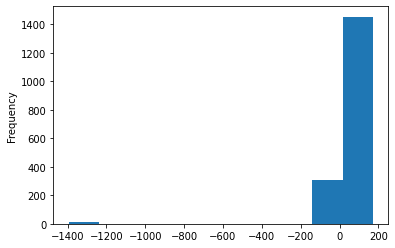

In [20]:
# create the time-columns in which the time-str and the timestamp are merged
df_session_tot["time"] = df_session_tot.apply(
    lambda r: r.timestamp.replace(
        **dict(zip(["hour", "minute", "second"], list(map(int, r.time_str.split(":")))))
    ),
    axis=1,
)
((df_session_tot.time - df_session_tot.timestamp).dt.total_seconds() / 60).plot.hist()


In [21]:
import numpy as np

test_arr = [1, 10, 3, 5, 2, 8, 100, 12, 200]
print(np.array(test_arr))
print(np.argsort(test_arr))
print(1 + np.argsort(np.argsort(test_arr)))


[  1  10   3   5   2   8 100  12 200]
[0 4 2 3 5 1 7 6 8]
[1 6 3 4 2 5 8 7 9]


In [22]:
df_session_tot["DB_no"] = df_session_tot.groupby(["ID", "DB"])["time"].apply(
    lambda s: 1 + s.argsort().argsort()
)
df_session_tot["session_no"] = df_session_tot.groupby(["ID"])["time"].apply(
    lambda s: 1 + s.argsort().argsort()
)

df_session_tot["pic_no"] = None
pic_mask = df_session_tot.DB != "marloes"
df_session_tot.loc[pic_mask, "pic_no"] = (
    df_session_tot[pic_mask]
    .groupby(["ID"])
    .time.apply(lambda s: 1 + s.argsort().argsort())
)


### Duration based visualizations

In [57]:
pv = df_session_tot[["DB", "wav_duration_s"]].pivot(
    columns="DB", values="wav_duration_s"
)
pv


DB,PiSCES,Radboud,marloes
0,NaN,NaN,12.20
1,22.14,NaN,NaN
2,NaN,31.27,NaN
3,35.80,NaN,NaN
4,NaN,28.37,NaN
5,24.96,NaN,NaN
6,NaN,NaN,12.12
7,NaN,31.32,NaN
8,44.25,NaN,NaN
9,NaN,24.75,NaN


In [58]:
pd.options.plotting.backend = "plotly"


In [59]:
import plotly.express as px


In [60]:
px.histogram(
    df_session_tot[["DB", "wav_duration_s"]].pivot(
        columns="DB", values="wav_duration_s"
    ),
    nbins=100,
    facet_row="DB",
    height=800,
    opacity=0.5,
)


is het fair om de assumptie te maken dat niemand middernacht de app heeft gebruikt?

### Investigating the file duration

In [73]:
(df_session_tot.wav_duration_s < 5).value_counts()


False    1757
True       19
Name: wav_duration_s, dtype: int64

In [92]:
df_session_tot[
    (df_session_tot.wav_duration_s < 15) & (df_session_tot.DB != "marloes")
].groupby(["ID", "timestamp", "DB", "prolific_token"]).size().to_frame()


0
ID                                   timestamp                        DB      prolific_token              
0e919efd-954e-4c12-98fb-dcf2d0a2b4e0 2022-06-29 18:55:57.528852+02:00 PiSCES  5eb9008b8224d385674c39b0   5
0e92d89e-a869-470f-8318-932da5107b24 2022-06-29 14:43:48.539686+02:00 PiSCES  5be03bf177e0190001b4ad0a   2
                                                                      Radboud 5be03bf177e0190001b4ad0a   1
1bf0c688-1152-4489-8af0-b2419b18f2bf 2022-06-29 18:46:27.440049+02:00 PiSCES  n.a.                       2
                                                                      Radboud n.a.                       6
3021f503-6e98-4c4a-8102-08ed581fa208 2022-06-23 11:42:14.555429+02:00 PiSCES  61649545e0a3638d8488f414   1
30e98ab0-b9c4-4dfe-a00f-1634bef1c426 2022-06-29 18:40:00.899255+02:00 PiSCES  6106e5fa2185277b70b2dc45   6
                                                                      Radboud 6106e5fa2185277b70b2dc45   4
31c59432-781c-4583-bba9-4d6d55be19e9 2022-07-16 12:13:19.043811+02:00 Radboud 5b1775aebdf4e10001631c75   4
565e07a3-e1b5-49b6-9aa3-8c9dea8fdc5e 2022-06-22 21:15:48.504448+02:00 PiSCES  60b01347f6fc32960811a1d0   2
                                                                      Radboud 60b01347f6fc32960811a1d0   2
795f5119-2b11-49f9-80ea-e5a5ef61f4bf 2022-07-17 13:09:11.536769+02:00 PiSCES  61115e026711eecf59e0e7ee   1
7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929 2022-07-18 14:21:44.926245+02:00 Radboud n.a.                       1
7f3bc021-b77d-4ae5-82d2-3cd406680246 2022-06-27 16:32:41.637487+02:00 PiSCES  n.a.                       1
                                                                      Radboud n.a.                       1
87eafb16-0598-4340-9564-8e630acf85d6 2022-07-16 13:40:19.209381+02:00 PiSCES  5da367636f69c500149e6216  15
                                                                      Radboud 5da367636f69c500149e6216  15
992fb536-7504-4c58-adaf-bd6498d96dc7 2022-06-23 12:09:48.679118+02:00 Radboud 61262a5bc13139179a45c068   1
9bd9b20c-97aa-4435-a704-149d55c4403a 2022-06-22 21:13:05.634330+02:00 PiSCES  5efe473e63271c33b8744de3   9
                                                                      Radboud 5efe473e63271c33b8744de3  12
a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f 2022-06-27 22:18:01.896264+02:00 PiSCES  5f2be3f5d81eaf0009520f8b  15
                                                                      Radboud 5f2be3f5d81eaf0009520f8b  15
a8fda205-f95f-4b90-b2b1-7b1c59af2f45 2022-07-16 18:05:53.427922+02:00 PiSCES  611539be6da4fd31733ef697   8
                                                                      Radboud 611539be6da4fd31733ef697  11
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 Radboud 5e360d610d43625c7da0a09d   1
c6a3fb30-04d8-470a-907b-6b81cfcdce83 2022-07-16 16:56:27.840661+02:00 Radboud n.a.                       2
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 PiSCES  5b0c1fdebd9c3100015641ae   8
                                                                      Radboud 5b0c1fdebd9c3100015641ae   6

In [77]:
# df_session_tot_cleaned[
#     (df_session_tot_cleaned.ID == "8b102c8b-afda-422d-88b2-9f5c8f7b3ccb") &
#     (df_session_tot_cleaned.DB == "Radboud")
# ]


### Filtering events

In [86]:
df_session_tot.shape


(1776, 22)

In [93]:
ids_to_skip = [
    "a97a84b6-7a66-461f-810e-b54bac686f64",
    "a2dbee10-fc31-42ec-89f8-9b4e5fa74b7f",
    "87eafb16-0598-4340-9564-8e630acf85d6",  # This prolific users does not want to be included into the data analysis
]

# we also skip this id
df_session_tot_cleaned = df_session_tot[
    (~df_session_tot.ID.isin(ids_to_skip)) & (df_session_tot.wav_size > 100)
]
df_session_tot_cleaned = df_session_tot_cleaned.sort_values(
    by=["ID", "time"], ignore_index=True
)
df_session_tot_cleaned.shape


(1693, 22)

In [94]:
df_session_tot_cleaned[
    (df_session_tot_cleaned.wav_duration_s < 15)
    & (df_session_tot_cleaned.DB != "marloes")
].groupby(["ID", "timestamp", "DB"]).size().to_frame()


0
ID                                   timestamp                        DB         
0e919efd-954e-4c12-98fb-dcf2d0a2b4e0 2022-06-29 18:55:57.528852+02:00 PiSCES    5
1bf0c688-1152-4489-8af0-b2419b18f2bf 2022-06-29 18:46:27.440049+02:00 PiSCES    2
                                                                      Radboud   6
1d259634-7d1a-461c-9098-5be8e94b105b 2022-06-10 16:28:57.737393+02:00 Radboud   1
3021f503-6e98-4c4a-8102-08ed581fa208 2022-06-23 11:42:14.555429+02:00 PiSCES    1
30e98ab0-b9c4-4dfe-a00f-1634bef1c426 2022-06-29 18:40:00.899255+02:00 PiSCES    6
                                                                      Radboud   4
31c59432-781c-4583-bba9-4d6d55be19e9 2022-07-16 12:13:19.043811+02:00 Radboud   4
565e07a3-e1b5-49b6-9aa3-8c9dea8fdc5e 2022-06-22 21:15:48.504448+02:00 PiSCES    2
                                                                      Radboud   2
6584e78d-d270-4183-b371-887e6f10acb0 2022-04-22 10:02:36.988266+02:00 PiSCES    4
                                                                      Radboud   2
7bca9b05-3c9a-4b4d-9e75-be0bd9bfc929 2022-07-18 14:21:44.926245+02:00 Radboud   1
7f3bc021-b77d-4ae5-82d2-3cd406680246 2022-06-27 16:32:41.637487+02:00 PiSCES    1
                                                                      Radboud   1
992fb536-7504-4c58-adaf-bd6498d96dc7 2022-06-23 12:09:48.679118+02:00 Radboud   1
9bd9b20c-97aa-4435-a704-149d55c4403a 2022-06-22 21:13:05.634330+02:00 PiSCES    9
                                                                      Radboud   8
a8fda205-f95f-4b90-b2b1-7b1c59af2f45 2022-07-16 18:05:53.427922+02:00 PiSCES    8
                                                                      Radboud  11
c30db4c2-a62a-4d69-8f1b-893a1f4b8c9d 2022-07-16 21:49:33.730743+02:00 Radboud   1
c6a3fb30-04d8-470a-907b-6b81cfcdce83 2022-07-16 16:56:27.840661+02:00 Radboud   2
e61cd702-cd5f-4258-b4ef-57665e20803c 2022-06-29 14:23:23.366587+02:00 PiSCES    8
                                                                      Radboud   6

In [40]:
df_session_tot_cleaned.to_parquet(
    loc_data_dir.joinpath("df_session_tot_cleaned.parquet")
)


NameError: name 'df_session_tot_cleaned' is not defined